# EIP-1559, estimated transaction fees revenues for miners

This notebook try to answer the following question:

"Can we estimate the economic impact of EIP-1559 on miners?"

There is already some works done on this subject on github. Most of them use a multi-agent simulation problem formulation like this repo: https://github.com/barnabemonnot/abm1559, or this one: https://github.com/gakonst/eip1559. 

In this notebook, we want to tackle this problem using ethereum historical transactions data. We hope to find some statistical properties from the gas price distriburion to get an estimate of the difference in miner's revenue caused by the upcoming eip-1559.

Here is a small definition of the eip-1559 from the ethereum website:

```
EIP 1559 is a proposal to reform the Ethereum fee market, with the following key changes:

    - The current gas limit of 12.5 million is replaced by two values: a “long-term average target” (12.5 million), and a “hard per-block cap” (25 million)

    - There is a BASEFEE (which is burned) which transactions are required to pay, which gets adjusted on a block-by-block basis with the goal of targeting a value so that average block gas usage remains around 12.5 million.

Essentially, instead of all of the short-term volatility in demand for transaction space within a block translating into volatility in transaction fees, some of the volatility instead translates into volatility in block size.
```

The BASEFEE in the eip-1559 will be the minimum gas price to pay in order to have a transaction mined into the next block. It's not trivial to "translate" this BASEFEE for the current legacy system. 

We cannot use the minimum gas price of the block to represent his BASEFEE, cause this is currently highly unpredictable (actually that's one of the thing eip-1559 will resolve). Instead, for a given block, to have an equivalent of what would have been an "estimated" BASEFEE on the current legacy ethereum blockchain, we can use the recommended gas price for that block. On this work we use the Geth recommendation algorithm (60th percentile of the last 100 blocks).

Thus, the following strong assumption is made: estimated BASEFEE = Geth gas price recommendation

The TIPS that will remain (FEES - BASEFEE) will be the part that will receive the miners from the transactions on the eip-1559 for a given transaction.

The proposed approach use the following observation:
 - On the historical ethereum data, we have periods of "normal" low variance gas price distribution (& close to the recomended price) VS periods with high variance gas price distribution (& far from the recommended price).

We will use this observation to filter the historical data and keep only periods that have a "centered" gas price distribution around the recommended gas price.

In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, LocalCluster

import matplotlib.pyplot as plt
import seaborn as sns

## Configurations

Select the dataset folder name generated by the first notebook (Big query).
The "ROLLING_WINDOW" parameter will be used as the length of the rolling average. This
rolling average is used to have our statistical metrics representing a small "portion" of blocks.
It will allow to reduce the noise in the analysis and allow to separate the low "overpay" blocks from the high "overpay" blocks.

In [2]:
configs = {
    "DATASET": "2019-01_to_2021-03_gas",
    "ROLLING_WINDOW": 20,
    "GROUP_1": ["2019-01", "2019-03"],
    "GROUP_2": ["2021-01", "2021-03"]
}

## Dask client

In [3]:
# DEFAULT USAGE
cluster = LocalCluster()
client = Client(cluster)
# USAGE WITH REMOTE CLUSTER
# client = Client('127.0.0.1:46363')
# client.restart()
client

Client Scheduler: tcp://127.0.0.1:46363 Dashboard: http://127.0.0.1:46365/status,Cluster Workers: 5 Cores: 10 Memory: 40.00 GB


## Loading Data

In [4]:
ddf = dd.read_parquet(f"datasets/{configs['DATASET']}", gather_statistics=True)
ddf["block_timestamp"] = dd.to_datetime(ddf["block_timestamp"]).dt.tz_localize(None)
ddf["gas_price"] = ddf["gas_price"] / 1000000000 # wei to gwei
ddf.head()

,block_timestamp,gas_price,gas
block_number,,,
6988615,2019-01-01 00:00:01,3.0,27991
6988615,2019-01-01 00:00:01,3.0,21000
6988615,2019-01-01 00:00:01,10.0,1000000
6988615,2019-01-01 00:00:01,2.4,21000
6988615,2019-01-01 00:00:01,10.0,250000


## Dataset description

In [5]:
print("Total number of transactions: ", len(ddf))

Total number of transactions:  660668362


Gas price distribution: 

Mean : 58.95510521522942 
Bin with most elements : 1


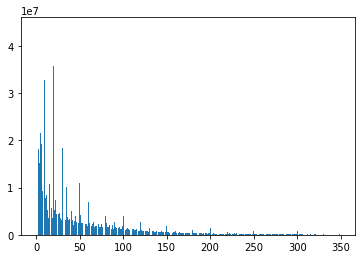

In [6]:
print("Gas price distribution: ")
print()
x = ddf["gas_price"].values

bins = 350

h, bins = da.histogram(x, bins=bins, range=[0, 350])
h = h.compute()
print(f"Mean : {x.mean().compute()} ")
print(f"Bin with most elements : {np.argmax(h)}")
plt.bar(bins[:-1], h)
plt.show()

Correlation between the gas and gas price: 


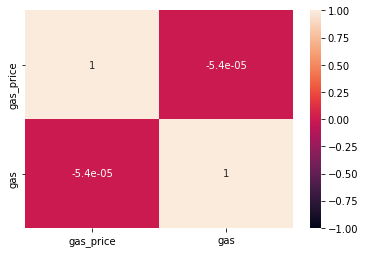

In [7]:
print("Correlation between the gas and gas price: ")

plot = sns.heatmap(ddf.corr().compute(), vmin=-1, vmax=1, annot=True)

Note: As expected, there is no correlation between the gas price and the amount of gas set for a transaction. Because of this, we can artificially construct a valid transaction history by randomly sampling transactions from a given period.

## Block-level analysis

In [8]:
def group_by_block(df: dd.DataFrame) -> dd.DataFrame:
    
    df_block = df.map_partitions(lambda part: part.groupby(part.index).agg({'gas_price': ['mean', 'min', 'max', 'count']}))
    df_median = df.map_partitions(lambda part: part.groupby(part.index)[["gas_price"]].apply(lambda x: x.quantile(0.5)))
    df_date = df.map_partitions(lambda part: part.groupby(part.index)[["block_timestamp"]].last())
    df_block.columns = ["gas_price_mean", "gas_price_min", "gas_price_max", "txs_count"]
    df_median.columns = ["gas_price_median"]
    df_date.columns = ["date"]
    return dd.concat([df_block, df_median, df_date], axis=1)

ddf_block = group_by_block(ddf)
ddf_block = client.persist(ddf_block) # comment this line if you are short in RAM
ddf_block_head = ddf_block.head()

ddf_block_head

,gas_price_mean,gas_price_min,gas_price_max,txs_count,gas_price_median,date
block_number,,,,,,
6988615,7.722222,2.4,20.0,9,3.0,2019-01-01 00:00:01
6988616,12.313851,2.0,80.0,81,3.0,2019-01-01 00:00:08
6988617,17.752113,1.0,350.0,143,5.0,2019-01-01 00:00:30
6988618,13.082658,3.0,99.0,120,8.0,2019-01-01 00:01:09
6988619,5.752326,3.0,23.0,86,3.0,2019-01-01 00:01:13


## Geth gas price recommendation algorithm

With the eip-1559, the users will have to set a "tips" on top of the base gas price (the base gas price will be burnt). Some variance in the gas price should be "absorbed" by the "flexibilty" of the block size. 
The eip-1559 should reduce by a lot the congestion periods (with high gas price overbidding). 

On top of that, it will become much easier to forecast the base gas price with high accuracy than on the current system. That's why we can actually assume in our analysis that the base gas price will be the "forecasted minimum gas price". Using the minimum gas price per block as the base gas price would be irrealistic because of the noisy nature of the minimum gas price per block (cf https://github.com/louisoutin/deep_gas_oracle). That's why I decided to use a realistic forecast as the "estimated base gas price": We define the forecast as being the 60th percentile of the minimum gas prices of the last 100 blocks.

Once we got this "estimated base gas price", we can compute the "estimated tips" as:

`estimated tips = gas price - estimated base gas price`

Note: For a given block, if a transaction inside this block is below the "estimated base gas price", we set the "estimated tips" to 0 for this transaction

In [9]:
def geth_recommend(ddf_block: dd.DataFrame, 
                   lookback: int = 100, 
                   percentile: int = 0.6) -> dd.DataFrame:
    """
    The Ethereum client implementation in go, namely Geth, accounts
    for over 79% of all Ethereum clients. To recommend a gas price, Geth uses
    the minimum gas price of the previous blocks. It looks back at the 100 blocks
    preceding the current one and then uses the value of the 60th percentile of the
    minimum gas prices as the price recommendation.
    """
    # todo: can be optimized
    reco = ddf_block[["gas_price_min"]].rolling(lookback).quantile(percentile)
    start_index = ddf_block.head().index[0]
    reco.columns = ["gas_price_recommendation"]
    reco = reco.loc[start_index+lookback:]
    return reco

def geth_and_estimated_tips(ddf_block: dd.DataFrame, 
                            ddf_geth_recommend: dd.DataFrame)-> dd.DataFrame:
    
    start_index = ddf_geth_recommend.head().index[0]
    ddf_block = ddf_block.loc[start_index:].copy()
    ddf_geth_recommend = ddf_geth_recommend.loc[start_index:].copy()
    estimated_tips = (ddf_block["gas_price_median"] - ddf_geth_recommend["gas_price_recommendation"])
    estimated_tips = estimated_tips.apply(lambda x: x if x > 0 else 0, meta="float")
    estimated_tips.name = "estimated_tips_median"
    return dd.concat([ddf_block, ddf_geth_recommend, estimated_tips], axis=1)

    
ddf_geth_recommend = geth_recommend(ddf_block)
ddf_block = geth_and_estimated_tips(ddf_block,ddf_geth_recommend )
start_index = ddf_geth_recommend.head().index[0]
ddf = ddf.loc[start_index:].copy()
ddf_block.head()

,gas_price_mean,gas_price_min,gas_price_max,txs_count,gas_price_median,date,gas_price_recommendation,estimated_tips_median
block_number,,,,,,,,
6988715,25.790394,3.3,350.0,108,11.115385,2019-01-01 00:24:14,3.0,8.115385
6988716,9.220141,3.0,134.0,65,4.000000,2019-01-01 00:24:27,3.0,1.000000
6988717,2.875018,2.0,10.0,86,2.400000,2019-01-01 00:24:29,3.0,0.000000
6988718,17.795414,2.0,350.0,151,10.000000,2019-01-01 00:25:21,3.0,7.000000
6988719,19.009101,3.0,350.0,94,10.000000,2019-01-01 00:25:26,3.0,7.000000


## Blocks rolling average

To analyse the gas price statistical "behaviors", we average the metrics over some blocks, to reduce noise and have a good picture of when people tends to overpay fees or when the fees are in general close to the recommended gas price (or "estimated BASEFEE").

In [10]:
NB_BLOCKS_TO_GROUP = configs["ROLLING_WINDOW"]

ddf_block_roll = ddf_block.rolling(NB_BLOCKS_TO_GROUP).mean()
ddf_block_roll = dd.concat([ddf_block_roll, ddf_block[["date"]]], axis=1)
start_index = ddf_block.head().index[0]+NB_BLOCKS_TO_GROUP
ddf_block_roll = ddf_block_roll.loc[start_index:].copy()
ddf_block_roll.columns = [c+"_rolling_mean" if c != "date" else "date" for c in ddf_block_roll.columns]
ddf_block_roll.head()

,gas_price_mean_rolling_mean,gas_price_min_rolling_mean,gas_price_max_rolling_mean,txs_count_rolling_mean,gas_price_median_rolling_mean,gas_price_recommendation_rolling_mean,estimated_tips_median_rolling_mean,date
block_number,,,,,,,,
6988735,18.304848,7.70,182.545,86.25,11.01689,2.577,8.62189,2019-01-01 00:31:35
6988736,18.585705,7.70,193.345,85.80,10.96689,2.529,8.61989,2019-01-01 00:31:44
6988737,20.172723,8.60,196.395,82.15,12.34689,2.502,9.99689,2019-01-01 00:32:01
6988738,21.782953,11.00,181.395,74.65,14.34689,2.502,11.99689,2019-01-01 00:32:03
6988739,22.471371,11.35,181.395,72.10,14.44689,2.502,12.09689,2019-01-01 00:32:05


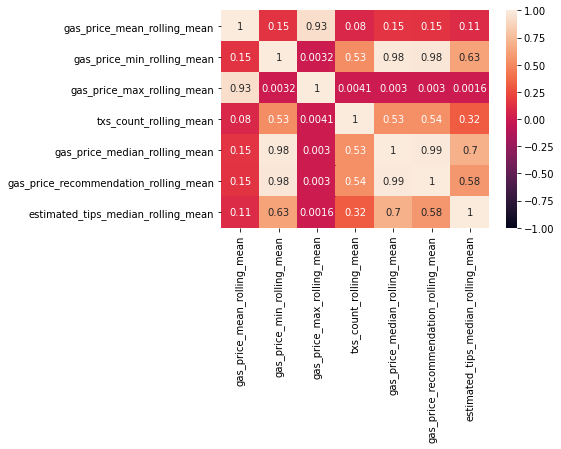

In [11]:
plot = sns.heatmap(ddf_block_roll.corr().compute(), vmin=-1, vmax=1, annot=True)

We notice that the average estimated tips are slightly correlated with the average gas price recommendation (0.58). 

In order to compute an estimation of what would have been the tips reward won by the miners under eip-1559, we will sample transactions that come from blocks from a period where most of the people were giving a relatively small tips (close to the geth recommendation). Still we want to include thoses ponctual outliers with very high gas price cause they likely will remain (flash loans, transactions that represent a high amount of eth, human error in the gas value typing ...). 

In [12]:
def show_histogram(ddf: dd.DataFrame, 
                   column: str="estimated_tips_median_rolling_mean", 
                   bins: int=100, 
                   max_range: int=100):
    
    x = ddf[column].values
    print(f"Histogram for feature: {column}:")
    h, bins = da.histogram(x, bins=bins, range=[0, max_range])
    h = h.compute()
    print(f"Mean : {x.mean().compute()} ")
    print(f"Bin with most elements : {np.argmax(h)}")
    plt.bar(bins[:-1], h)
    plt.show()

Histogram for feature: estimated_tips_median_rolling_mean:
Mean : 8.49011064469163 
Bin with most elements : 4


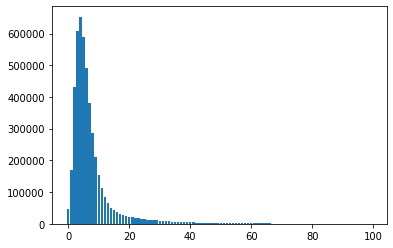

In [13]:
show_histogram(ddf_block_roll)

Histogram for feature: txs_count_rolling_mean:
Mean : 137.08578161309015 
Bin with most elements : 48


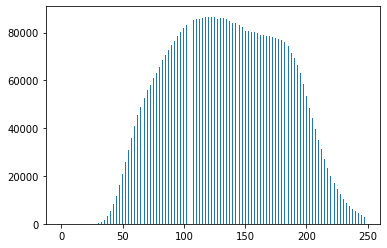

Histogram for feature: gas_price_median_rolling_mean:
Mean : 38.61996390822418 
Bin with most elements : 7


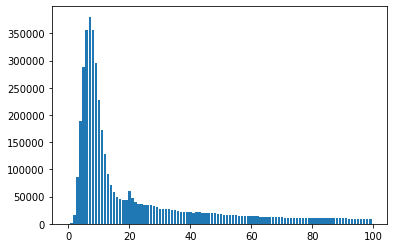

Histogram for feature: gas_price_recommendation_rolling_mean:
Mean : 31.140895113097926 
Bin with most elements : 1


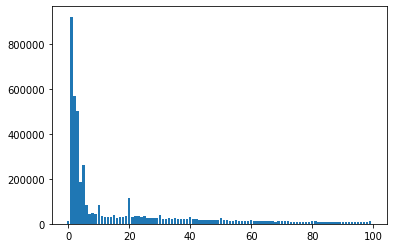

In [14]:
show_histogram(ddf_block_roll, "txs_count_rolling_mean", max_range=250)
show_histogram(ddf_block_roll, "gas_price_median_rolling_mean")
show_histogram(ddf_block_roll, "gas_price_recommendation_rolling_mean")

From 2019-01 to 2019-03 :

Histogram for feature: estimated_tips_median_rolling_mean:
Mean : 6.705204891272022 
Bin with most elements : 5


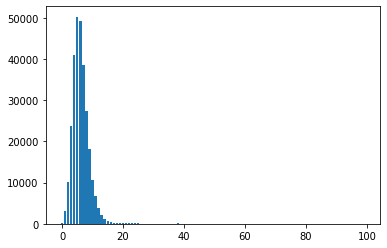

From 2021-01 to 2021-03 :

Histogram for feature: estimated_tips_median_rolling_mean:
Mean : 25.63046763730331 
Bin with most elements : 10


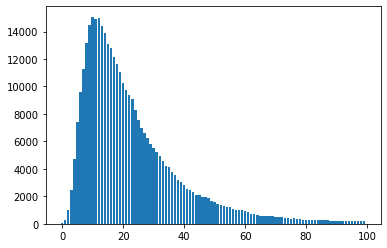

In [15]:
GROUP_1 = configs["GROUP_1"]
GROUP_2 = configs["GROUP_2"]

print(f"From {GROUP_1[0]} to {GROUP_1[1]} :\n")

group_1 = ddf_block_roll.loc[(ddf_block_roll["date"] >= GROUP_1[0]) & (ddf_block_roll["date"] < GROUP_1[1])].copy()
show_histogram(group_1)

print(f"From {GROUP_2[0]} to {GROUP_2[1]} :\n")

group_2 = ddf_block_roll.loc[(ddf_block_roll["date"] >= GROUP_2[0]) & (ddf_block_roll["date"] < GROUP_2[1])].copy()
show_histogram(group_2)

We can see that from January to March 2019, the averaged "estimated tips" are lower than the ones from January to March 2021 . But more than that, the distribution looks like a normal distribution on the period of 2019 whereas the distriution on the same period on 2021 is highly skewed to the right (because of the high costs of the fees on ethereum on the later period)

For that reason, we will clip the historical data to only keep periods close to the most given averaged "estimated tips": 4. (we thus clip every rows with a value higher than 10 to get some variance and obtain sort of a "normal distribution" centered on 4)

This clipped dataset will be our reference to sample transactions from. It simulate the fact that eip-1559 will remove this variance in the gas price (cf "all of the short-term volatility in demand for transaction space within a block translating into volatility in transaction fees [for current system]")

Histogram for feature: estimated_tips_median_rolling_mean:
Mean : 5.242975250049051 
Bin with most elements : 4


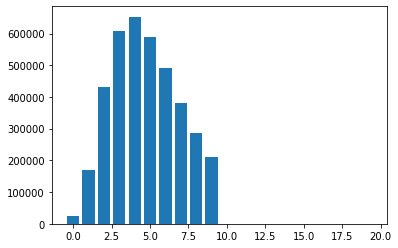

In [16]:
MIN_CLIP = 0.5
MAX_CLIP = 10

ddf_low_tips = ddf_block_roll[(ddf_block_roll["estimated_tips_median_rolling_mean"] > MIN_CLIP) & (ddf_block_roll["estimated_tips_median_rolling_mean"] <= MAX_CLIP)]
show_histogram(ddf_low_tips, bins=20, max_range=20)

By clipping the value above 10, the distribution now almost follow a gaussian distribution. We could expect such distribution on eip-1559

TRANSACTIONS COUNT AVERAGED DISTRIBUTION :
Histogram for feature: txs_count_rolling_mean:
Mean : 127.28539683720619 
Bin with most elements : 48


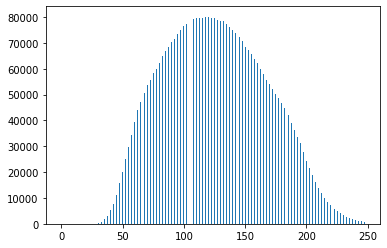

GAS PRICE MEDIAN AVERAGED DISTRIBUTION :
Histogram for feature: gas_price_median_rolling_mean:
Mean : 20.640571185550783 
Bin with most elements : 7


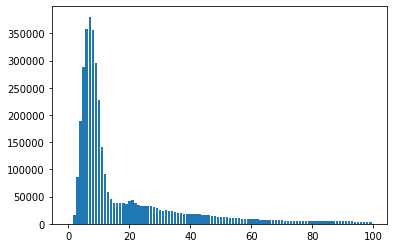

GAS PRICE RECOMMENDATION AVERAGED DISTRIBUTION :
Histogram for feature: gas_price_recommendation_rolling_mean:
Mean : 15.941287760953822 
Bin with most elements : 1


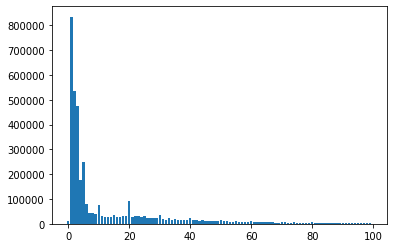

In [17]:
print("TRANSACTIONS COUNT AVERAGED DISTRIBUTION :")
show_histogram(ddf_low_tips, "txs_count_rolling_mean", max_range=250)
print("GAS PRICE MEDIAN AVERAGED DISTRIBUTION :")
show_histogram(ddf_low_tips, "gas_price_median_rolling_mean")
print("GAS PRICE RECOMMENDATION AVERAGED DISTRIBUTION :")
show_histogram(ddf_low_tips, "gas_price_recommendation_rolling_mean")

We can see that despite removing all blocks with a high difference from the median tips to the estimated BASEFEE, the properties of the sampled dataset reamins the same (same distribution in the others variables)

## Distincts periods comparison

To have a visual idea of how different can be the variance in the gas price distribution, we can plot a boxplot of the gas prices for each blocks over multiple timestamps.

Here, we compare a period of 20 consective blocks choosen randomly on the ethereum historical data where we had clear gas price overpayments VERSUS another series where the gas price distribution was much lower/normal, with small variance

Note: We sample the 2 examples to have a similar gas price recommendation ("estimated base") for an easier comparison

In [18]:
def plot_multiple_blocks_gas_price_distr(ddf_txs: dd.DataFrame,
                                         ddf_recommendation: dd.DataFrame,
                                         start_block_number: int,
                                         length: int = 20,
                                         clip_max: float = None):
    end_block_number = start_block_number + length
    ddf_txs = ddf_txs.reset_index()
    ddf_recommendation = ddf_recommendation[["gas_price_recommendation"]]
    ddf_recommendation = ddf_recommendation.reset_index()
    ddf_recommendation.columns = ["block_number", "gas_price_recommendation"]
    ddf_txs = ddf_txs[(ddf_txs["block_number"] >= start_block_number) &
                      (ddf_txs["block_number"] <= end_block_number)].compute()
    ddf_recommendation = ddf_recommendation[(ddf_recommendation["block_number"] >= start_block_number) &
                                            (ddf_recommendation["block_number"] <= end_block_number)].compute()
    if clip_max is not None:
        ddf_txs["gas_price"] = ddf_txs["gas_price"].clip(0, clip_max)
    ddf_txs[["block_number", "gas_price"]].boxplot(by="block_number", figsize=(30,10))
    plt.plot(range(1,len(ddf_recommendation)+1), ddf_recommendation[["gas_price_recommendation"]].values, 'k-', lw=2)
    #plt.plot(range(1,len(df_recommendation)+1), df_txs.groupby("block_number")[["gas_price"]].mean(), 'k-', lw=1)

In [19]:
PREFERED_BASE_PRICE = 50

high_fees_blocks = ddf_block_roll.nlargest(10000, 'estimated_tips_median_rolling_mean').index.values.compute()
low_fees_blocks = ddf_low_tips.index.values.compute()

low_reco_prices = (ddf_low_tips["gas_price_recommendation_rolling_mean"]).astype(int).unique().compute()
ddf_high_tips = ddf_block_roll.nlargest(500000, 'estimated_tips_median_rolling_mean')
high_reco_prices = (ddf_high_tips["gas_price_recommendation_rolling_mean"]).astype(int).unique().compute()
reco_prices_intersec = list(set(low_reco_prices).intersection(set(high_reco_prices)))

if PREFERED_BASE_PRICE in reco_prices_intersec:
    reco_price = PREFERED_BASE_PRICE
else:
    reco_price = np.random.choice(reco_prices_intersec, 1)[0]
print("recommended price for plot :", reco_price)

recommended price for plot : 50


HIGH FEES VARIANCE RANDOM EXAMPLE from block 10982972 to block 10982992 :


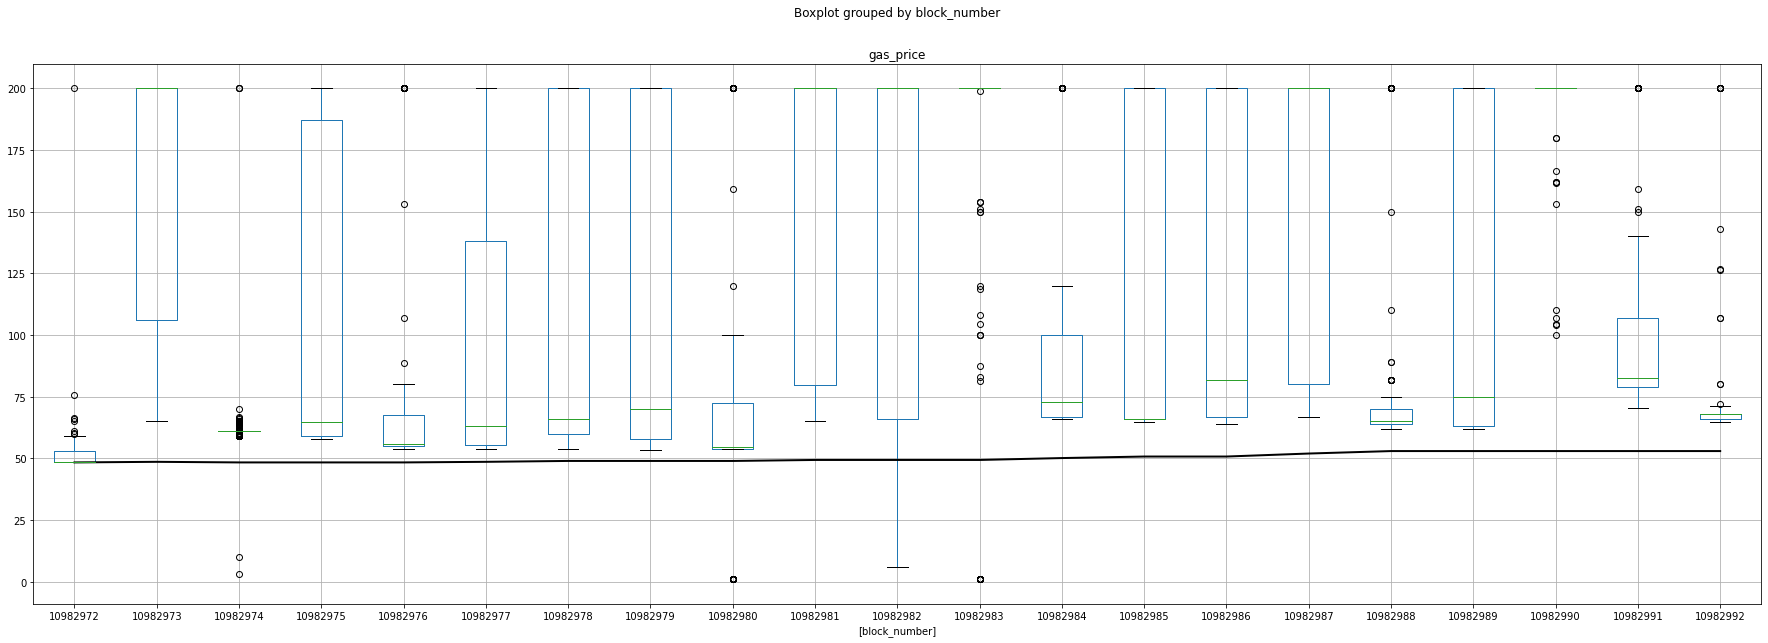

In [20]:
idxs_reco_price = ddf_block_roll.loc[(ddf_block_roll["gas_price_recommendation_rolling_mean"] < reco_price+1) &
                                     (ddf_block_roll["gas_price_recommendation_rolling_mean"] > reco_price-1) &
                                     (ddf_block_roll.index.isin(high_fees_blocks))].index
block_high = np.random.choice(idxs_reco_price, 1)[0]
print(f"HIGH FEES VARIANCE RANDOM EXAMPLE from block {block_high-20} to block {block_high} :")
plot_multiple_blocks_gas_price_distr(ddf, ddf_block[["gas_price_recommendation"]], block_high-20, clip_max=200)

LOW FEES VARIANCE RANDOM EXAMPLE from block 11309432 to block 11309452 :


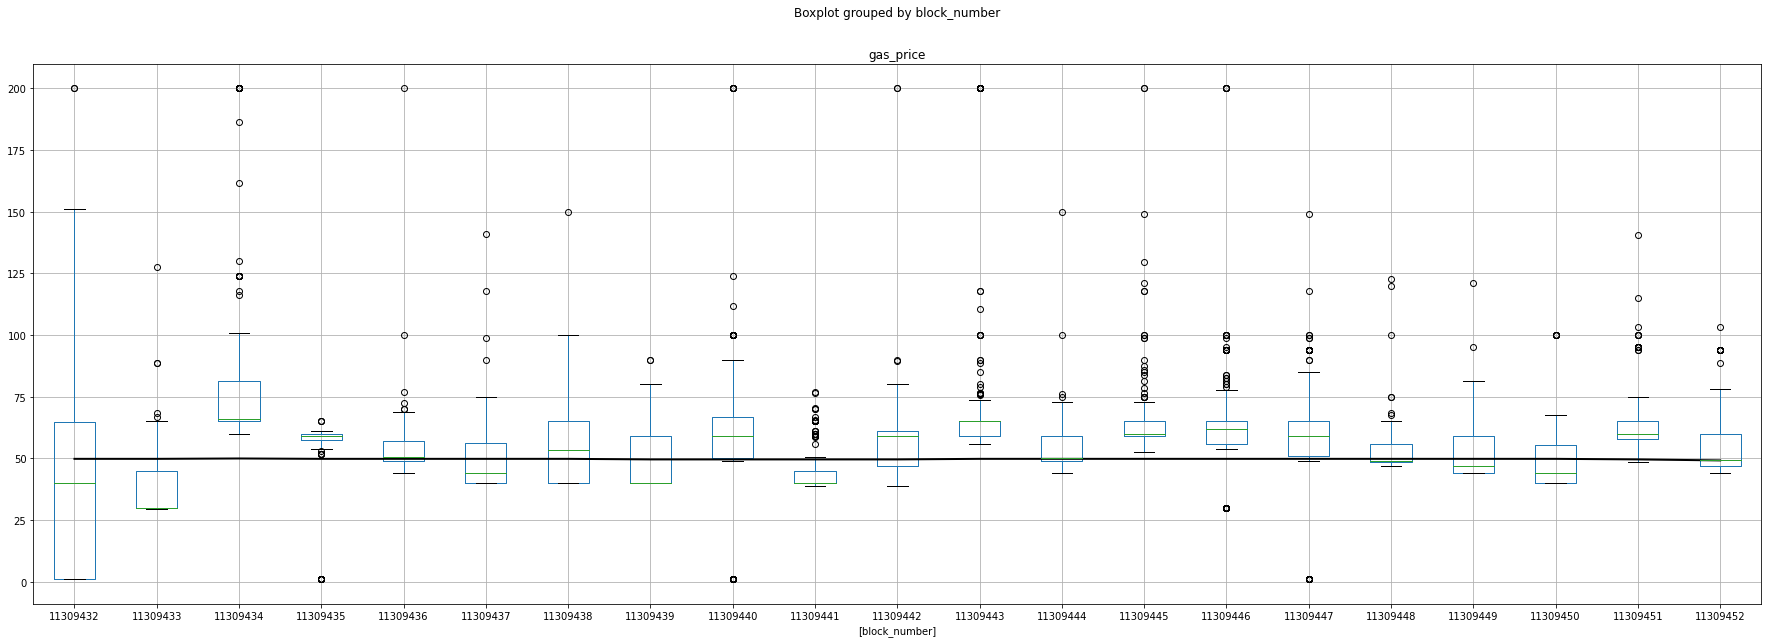

In [21]:
idxs_reco_price = ddf_low_tips.loc[(ddf_low_tips["gas_price_recommendation_rolling_mean"] < reco_price+1) &
                                (ddf_low_tips["gas_price_recommendation_rolling_mean"] > reco_price-1)].index
block_low = np.random.choice(idxs_reco_price, 1)[0]
print(f"LOW FEES VARIANCE RANDOM EXAMPLE from block {block_low-20} to block {block_low} :")
plot_multiple_blocks_gas_price_distr(ddf, ddf_block[["gas_price_recommendation"]], block_low-20, clip_max=200)

We can see that the first plot of the gas price distribution over consecutive blocks have some very high "overpaying gas prices". In comparison, the second plot that is sampled from low overpayment consecutive blocks, have a much smaller and consistent variance.

Note: In both case, we can see some extreme gas price (outliers). We can believe that thoses outliers will remain even after the adoption of eip-1559 (transactions with high eth value, human error, flash loans, bots, etc).

## Estimation results

On this section, we will compare 3 cases:

1. Actual miners profit made (legacy blockchain)
2. Estimation of miners profit made with eip-1559 (without remove periods with fees overpayments)
3. Estimation of miners profit made with eip-1559 (with removing periods with fees overpayments)

Computation 2) can be considered as a minimum loss in revenues for miners while computation 3) can be considered as a more realistic estimation (given the assumptions of this notebook of course)

In [22]:
def compute_actual_miners_profit(ddf: dd.DataFrame, 
                                 from_date:str = "2019-01", 
                                 to_date:str = "2021-02") -> float:
    
    ddf = ddf.loc[((ddf["block_timestamp"] >= from_date) & (ddf["block_timestamp"] <= to_date))]
    return (ddf["gas_price"] * ddf["gas"]).sum().compute() / 1000000000 # to eth

In [23]:
def compute_eip1559_miners_profit(ddf: dd.DataFrame, 
                                  df_recommendation: dd.DataFrame, 
                                  from_date:str = "2019-01", 
                                  to_date:str = "2021-02") -> float:
    
    ddf = ddf.loc[((ddf["block_timestamp"] >= from_date) & (ddf["block_timestamp"] <= to_date))]
    ddf = ddf.merge(ddf_block[["gas_price_recommendation"]], left_index=True, right_index=True, how='left')
    ddf["gas_price"] = ddf["gas_price"] - ddf["gas_price_recommendation"]
    ddf["gas_price"] = ddf["gas_price"].apply(lambda x: x if x > 0 else 0, meta="float")
    return (ddf["gas_price"] * ddf["gas"]).sum().compute() / 1000000000 # to eth

In [24]:
def compute_refined_eip1559_miners_profit(low_tips_idxs: np.array, 
                                          ddf: dd.DataFrame,
                                          ddf_recommendation: dd.DataFrame,
                                          from_date:str = "2019-01",
                                          to_date:str = "2021-02") -> float:
    
    ddf = ddf.loc[((ddf["block_timestamp"] >= from_date) & (ddf["block_timestamp"] <= to_date))]
    df_subset_txs = ddf.loc[ddf.index.isin(low_tips_idxs)].copy()
    len_multiplier = len(ddf) / len(df_subset_txs)
    return compute_eip1559_miners_profit(df_subset_txs, ddf_recommendation, from_date, to_date) * len_multiplier

In [25]:
def estimate_profit(ddf: dd.DataFrame,
                    ddf_recommendation: dd.DataFrame,
                    low_fees_blocks: np.array,
                    from_date:str = "2019-01", 
                    to_date:str = "2021-02") -> tuple:
    
    print(f"Range: {from_date} to {to_date}\n")
    # Actual profit: the current fees system
    actual_profit = compute_actual_miners_profit(ddf, from_date=from_date, to_date=to_date)
    print(f"Current miners profit from fees was {actual_profit:.2f} ETH\n")
    # Estimated profit upper bound: substract the gas recommendation ("estimated base gas price") only
    estimated_profit = compute_eip1559_miners_profit(ddf, ddf_recommendation,
                                                     from_date=from_date, to_date=to_date)
    print(f"Estimated (upper bound) miners profit from fees with eip 1559 is {estimated_profit:.2f} ETH")
    loss = 1 - (estimated_profit/actual_profit)
    print(f"-> loss of {loss*100:.2f}% \n")
    # Estimated profit: same as above + only samples from period with "normal/low" fees
    refined_estimated_profit = compute_refined_eip1559_miners_profit(low_fees_blocks, ddf, 
                                                                     ddf_recommendation,
                                                                     from_date=from_date, to_date=to_date)
    print(f"Estimated miners profit from fees with the eip 1559 is {refined_estimated_profit:.2f} ETH")
    loss = 1 - (refined_estimated_profit/actual_profit)
    print(f"-> loss of {loss*100:.2f}% \n")
    
    return actual_profit, estimated_profit, refined_estimated_profit

## Evaluation from January 2019 to February 2021

In [26]:
df_recommendation = ddf_block[["gas_price_recommendation"]]
estimation = estimate_profit(ddf, df_recommendation, low_fees_blocks)

Range: 2019-01 to 2021-02

Current miners profit from fees was 5808504.00 ETH

Estimated (upper bound) miners profit from fees with eip 1559 is 1990323.65 ETH
-> loss of 65.73% 

Estimated miners profit from fees with the eip 1559 is 1363807.34 ETH
-> loss of 76.52% 



## Evaluation from January to March 2019

In [27]:
estimation_2019 = estimate_profit(ddf, df_recommendation, low_fees_blocks, from_date="2019-01", to_date="2019-03")

Range: 2019-01 to 2019-03

Current miners profit from fees was 100871.54 ETH

Estimated (upper bound) miners profit from fees with eip 1559 is 73309.27 ETH
-> loss of 27.32% 

Estimated miners profit from fees with the eip 1559 is 65989.44 ETH
-> loss of 34.58% 



## Evaluation from January to March 2021

In [28]:
estimation_2021 = estimate_profit(ddf, df_recommendation, low_fees_blocks, from_date="2021-01", to_date="2021-03")

Range: 2021-01 to 2021-03

Current miners profit from fees was 1963751.95 ETH

Estimated (upper bound) miners profit from fees with eip 1559 is 587791.73 ETH
-> loss of 70.07% 

Estimated miners profit from fees with the eip 1559 is 262721.43 ETH
-> loss of 86.62% 



In [29]:
df_res = pd.DataFrame({'2019-01 to 2021-03': estimation, '2019-01 to 2019-03': estimation_2019, '2021-01 to 2021-03': estimation_2021})
df_res.index = ["actual", "estimated (upper bound)", "estimated"]
df_res

,2019-01 to 2021-03,2019-01 to 2019-03,2021-01 to 2021-03
actual,5.808504e+06,100871.544314,1.963752e+06
estimated (upper bound),1.990324e+06,73309.271849,5.877917e+05
estimated,1.363807e+06,65989.443951,2.627214e+05


## Outliers analysis

In this last section, let's just see what are the proportion of miner's revenues coming from the "outliers" transactions (the ones with high gas fees compared to the rest of the block)

Here we define a block outlier as: 

    - greater than 75th percentile + (1.5 * InterQuartileRange)

In [30]:

def above_percentile(x):
    q1 = np.percentile(x["gas_price"], 25)
    q3 = np.percentile(x["gas_price"], 75)
    iqr = q3 - q1
    thr = q3 + 1.5 * iqr
    outliers = x[x["gas_price"] >= thr]
    return (outliers["gas_price"] * outliers["gas"]).sum()

def outliers_fees(ddf: dd.DataFrame, 
                  from_date: str = "2019-01",
                  to_date: str = "2019-03") -> float:
    ddf_for_outliers = ddf.loc[((ddf["block_timestamp"] >= from_date) & (ddf["block_timestamp"] <= to_date))]
    return ddf_for_outliers.map_partitions(lambda part: part.groupby(part.index)[["gas_price", "gas"]].apply(above_percentile)).sum().compute() / 1000000000 # to eth


## Outliers from 2019-01 to 2019-03

In [31]:
outliers_2019 = outliers_fees(ddf, from_date="2019-01", to_date="2019-03")
ratio_outliers_2019 = outliers_2019 / estimation_2019[0]
print(f"Range: 2019-01 to 2019-03\n")
print(f"The fees coming from the detected outliers transactions correspond to : {outliers_2019:.2f} ETH")
print(f"This amount represent {ratio_outliers_2019*100:.2f}% of the total fees on this period")

Range: 2019-01 to 2019-03

The fees coming from the detected outliers transactions correspond to : 34059.21 ETH
This amount represent 33.76% of the total fees on this period


## Outliers from 2021-01 to 2021-03

In [32]:
outliers_2021 = outliers_fees(ddf, from_date="2021-01", to_date="2021-03")
ratio_outliers_2021 = outliers_2021 / estimation_2021[0]
print(f"Range: 2021-01 to 2021-03\n")
print(f"The fees coming from the detected outliers transactions correspond to : {outliers_2021:.2f} ETH")
print(f"This amount represent {ratio_outliers_2021*100:.2f}% of the total fees on this period")

Range: 2021-01 to 2021-03

The fees coming from the detected outliers transactions correspond to : 375088.22 ETH
This amount represent 19.10% of the total fees on this period
